In [66]:
%matplotlib inline

#Libraries
import tensorflow as tf
import cv2
import numpy as np
import random
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tqdm import tqdm
from matplotlib import pyplot as plt


In [67]:
#Model to be used on the classification. To keep things simple,
#I started with a MobilenetV3SMall with the Imagenet weights.
model = tf.keras.applications.MobileNetV3Small(
    include_top=True,
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax",
    alpha=0.75
)

In [68]:
def modify_image(image: cv2.Mat, pixels_per_it = 1) -> cv2.Mat:
    ''' Modify an image by randomly changing its pixel colors'''
    h,w,c = image.shape
    for _ in range(pixels_per_it):
        random_h = random.randint(0,h - 1)
        random_w = random.randint(0,w - 1)
        random_color = []
        for _ in range(c):
            random_color.append(random.randint(0,255))
        image[random_h][random_w] = random_color
    return image

Text(0.5, 1.0, 'Original image')

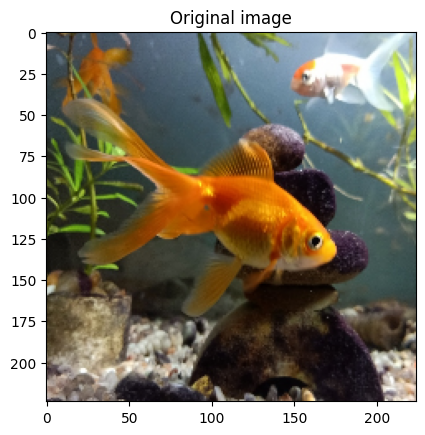

In [69]:
# Loads the image, then show it
current_image = cv2.imread("goldfish.jpg",cv2.IMREAD_COLOR)
current_image = cv2.cvtColor(current_image,cv2.COLOR_BGR2RGB)
current_image = cv2.resize(current_image,(224,224))
plt.imshow(current_image)
plt.title("Original image")

In [70]:
starting_preds = model.predict(np.expand_dims(current_image,axis=0),verbose=0,use_multiprocessing=True, workers=8)
decode_predictions(starting_preds)

[[('n01443537', 'goldfish', 0.6793853),
  ('n01950731', 'sea_slug', 0.053552095),
  ('n09256479', 'coral_reef', 0.034130067),
  ('n02317335', 'starfish', 0.03150646),
  ('n01914609', 'sea_anemone', 0.024649695)]]

In [71]:
predicted_class = starting_preds.argmax()
print(f"Class index: {predicted_class}")

Class index: 1


In [72]:
#Forcing the real label to be what the network predicted
label = starting_preds * 0
label[0][predicted_class] = 1

loss: 1.0502055883407593, achieved on it 404, changes: 66: 100%|██████████| 500/500 [00:21<00:00, 23.15it/s]


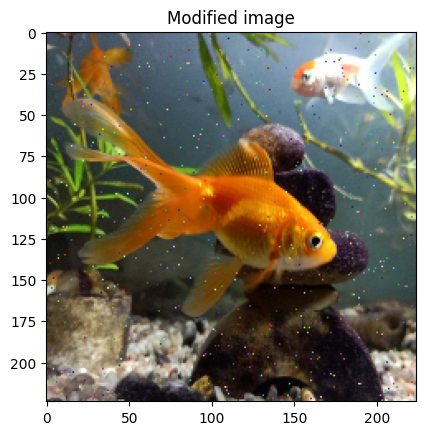

In [73]:
iterations = 500 # How many times the attack will be run
changes = []      # list containing all loss changes
categorical_cross_entropy = tf.keras.losses.CategoricalCrossentropy()
biggest_loss = 0
failed_attacks = 0
fails = []
pbar = tqdm(range(iterations))

for i in pbar:
    image = modify_image(current_image)
    preds = model.predict(np.expand_dims(image,axis=0),verbose=0,use_multiprocessing=True, workers=8)
    loss =  categorical_cross_entropy(y_true=label,y_pred=preds).numpy()
    if loss > biggest_loss:
        biggest_loss = loss
        current_image = image
        changes.append(loss)
        fails.append(failed_attacks)
        failed_attacks = 0
        pbar.set_description(f"loss: {biggest_loss}, achieved on it {i}, changes: {len(changes)}")
    else:
        failed_attacks += 1 
    plt.imshow(current_image)
    plt.title("Modified image")


In [74]:
#Checking the scores
print(f"Starting predictions {decode_predictions(starting_preds)}")
preds = model.predict(np.expand_dims(current_image,axis=0),verbose=0,use_multiprocessing=True, workers=8)
print(f"After {len(changes)} single pixel attacks: {decode_predictions(preds)}")


Starting predictions [[('n01443537', 'goldfish', 0.6793853), ('n01950731', 'sea_slug', 0.053552095), ('n09256479', 'coral_reef', 0.034130067), ('n02317335', 'starfish', 0.03150646), ('n01914609', 'sea_anemone', 0.024649695)]]
After 66 single pixel attacks: [[('n01950731', 'sea_slug', 0.37878543), ('n01443537', 'goldfish', 0.37562165), ('n01914609', 'sea_anemone', 0.06561352), ('n09256479', 'coral_reef', 0.03586824), ('n02317335', 'starfish', 0.017939646)]]


In [4]:
print("[[('n01950731', 'sea_slug', 0.37878543), \n('n01443537', 'goldfish', 0.37562165), \n('n01914609', 'sea_anemone', 0.06561352), \n('n09256479', 'coral_reef', 0.03586824), \n('n02317335', 'starfish', 0.017939646)]]")

[[('n01950731', 'sea_slug', 0.37878543), 
('n01443537', 'goldfish', 0.37562165), 
('n01914609', 'sea_anemone', 0.06561352), 
('n09256479', 'coral_reef', 0.03586824), 
('n02317335', 'starfish', 0.017939646)]]


In [5]:
plt.plot(starting_preds[0])
plt.xlabel('Class index')
plt.ylabel('Probability')

NameError: name 'plt' is not defined

Text(0, 0.5, 'Probability')

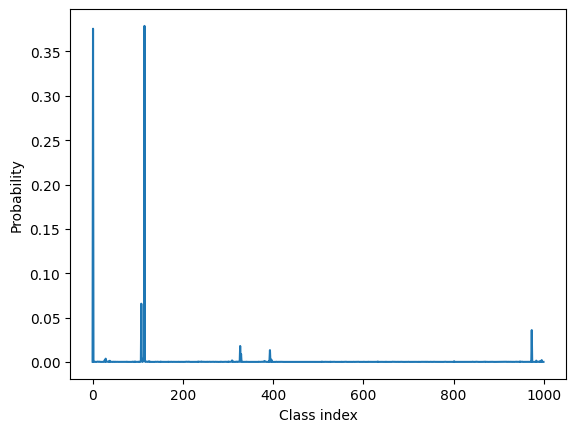

In [ ]:
plt.plot(preds[0])
plt.xlabel('Class index')
plt.ylabel('Probability')

Text(0, 0.5, 'Loss')

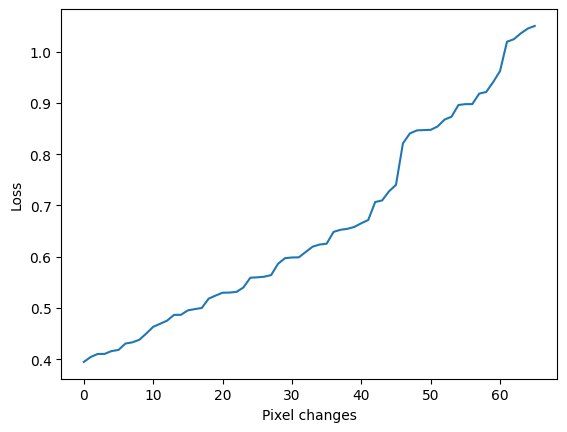

In [ ]:
#Plotting the results
plt.plot(changes)
plt.xlabel('Pixel changes')
plt.ylabel('Loss')
